In [375]:
# imports
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [376]:
# problem parameters
num_qubits = 3
numx       = num_qubits
shots      = None
reps_reup  = 1
reps_var   = 1

In [377]:
# QNN model
dev = qml.device('default.qubit', wires=num_qubits, shots=shots)

@qml.qnode(dev, interface='torch')
def qnn_model(x, varw_init, varw, obsw):
    for i in range(reps_reup):
        qml.IQPEmbedding(x, wires=range(num_qubits))
        qml.SimplifiedTwoDesign(initial_layer_weights=varw_init, weights=varw, wires=range(num_qubits))

    obs = [qml.PauliZ(q) for q in range(num_qubits)]
    H   = qml.Hamiltonian(obsw, obs)
    return qml.expval(H)

tensor(0., dtype=torch.float64)


/tmp/ipykernel_15590/3810792534.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


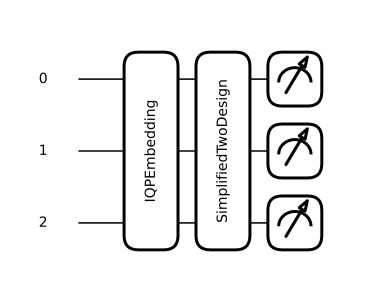

In [378]:
# draw
x          = np.zeros(numx)
theta_init = np.zeros(num_qubits)
theta      = np.zeros((reps_var, num_qubits-1, 2))
ck         = np.ones(num_qubits)
print(qnn_model(x, theta_init, theta, ck))
fig, ax    = qml.draw_mpl(qnn_model)(x, theta_init, theta, ck)
fig.show()

In [379]:
# data example
data       = [[0.1, 0.2, 15.], [0.5, 0.8, 100.]]
input      = data
labels     = [[0.22], [16.]]

input_min   = [0., 0., 0.]
input_max   = [0.52, 1000., 1000.]
labels_min  = [0.]
labels_max  = [1000.]

# normalize data
scaler      = MinMaxScaler()
#scaler.fit([input_min, input_max])
input_norm  = scaler.fit_transform(input)
#scaler.fit([labels_min, labels_max])
labels_norm = scaler.fit_transform(labels)
labels_norm = labels_norm.reshape(len(labels))

In [380]:
# init pytorch parameters
torch.manual_seed(0)
theta_init  = torch.randn(num_qubits, requires_grad=True)
theta       = torch.randn(reps_var, num_qubits-1, 2, requires_grad=True)
ck          = torch.randn(num_qubits, requires_grad=True)
input_norm  = torch.tensor(input_norm, requires_grad=False)
labels_norm = torch.tensor(labels_norm, requires_grad=False)

In [381]:
# cost function
def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

def cost(theta_init, theta, ck):
    pred = [qnn_model(x, theta_init, theta, ck) for x in input_norm]
    loss = square_loss(pred, labels_norm)
    return loss

In [382]:
# optimize
steps = 100
opt   = torch.optim.Adam([theta_init, theta, ck], lr=0.1)

for n in range(steps):
    opt.zero_grad()
    loss = cost(theta_init, theta, ck)
    loss.backward()
    opt.step()

    if n%10 == 9 or n == steps - 1:
        print(f'{n+1}: {loss}') 

10: 0.0010593498875811572
20: 0.003943063568226711
30: 0.0021203522652350226
40: 0.0003209111808457802
50: 7.093249650298315e-05
60: 7.010770708867423e-05
70: 4.09179500802704e-05
80: 1.533934387504904e-05
90: 3.88904611665023e-06
100: 7.844649522335124e-07


In [389]:
# test
print([qnn_model(x, theta_init, theta, ck) for x in input_norm])
print(labels_norm)

[tensor(0.0020, dtype=torch.float64, grad_fn=<SqueezeBackward0>), tensor(0.9986, dtype=torch.float64, grad_fn=<SqueezeBackward0>)]
tensor([0., 1.], dtype=torch.float64)
